#### Prepare

In [1]:
!pip list

Package                          Version
-------------------------------- ---------------------
absl-py                          1.4.0
aiohttp                          3.9.5
aiosignal                        1.3.1
alabaster                        0.7.16
albumentations                   1.3.1
altair                           4.2.2
annotated-types                  0.6.0
anyio                            3.7.1
appdirs                          1.4.4
argon2-cffi                      23.1.0
argon2-cffi-bindings             21.2.0
array_record                     0.5.1
arviz                            0.15.1
astropy                          5.3.4
astunparse                       1.6.3
async-timeout                    4.0.3
atpublic                         4.1.0
attrs                            23.2.0
audioread                        3.0.1
autograd                         1.6.2
Babel                            2.14.0
backcall                         0.2.0
beautifulsoup4                   4.12.3


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import io
from sklearn.model_selection import train_test_split
from keras.preprocessing.sequence import pad_sequences

import torch
from torch.utils.data import DataLoader, TensorDataset, RandomSampler, SequentialSampler
from torch.optim.lr_scheduler import ExponentialLR

from transformers import BertTokenizer, BertConfig, BertModel
from transformers import AdamW, BertForSequenceClassification, get_linear_schedule_with_warmup

from tqdm import tqdm, trange

import warnings
warnings.filterwarnings("ignore")

#### Preprocessing

In [3]:
# data from drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [43]:
error_count = 0
try:
    df = pd.read_csv("/content/drive/MyDrive/data/crime_data/train_data.txt", delimiter='\t', header=None, names=['label', 'sentence'], on_bad_lines='skip')
except pd.errors.ParserError as e:
    print(f"Parser error occurred: {str(e)}")
    error_count = error_count + 1;
    df = pd.read_csv("/content/drive/MyDrive/data/crime_data/train_data.txt", delimiter='\t', header=None, names=['label', 'sentence'], on_bad_lines='skip')

In [45]:
print("error count: " + str(error_count))

error count: 0


In [44]:
# check unique labels
unique_labels = df['label'].unique()

label_map = {}
for i, label in enumerate(unique_labels):
    label_map[label] = i

print(unique_labels)


['盗窃罪' '故意伤害罪' '危险驾驶罪' '诈骗罪'
 '诈骗罪告人周某某于2013年11月26日，在江门市新会区会城冈州大道中106号105汇兴寄售行内，采取虚构其朋友在为冼某某申办卡号为4581247614882484的交通银行信用卡时已为该卡存入保证金的事实并要求被害人冼某某归还上述保证金的手段，诈骗得冼的现金人民币10000元。×告人周某某于同年12月6日至同月8日期间，利用为冼某某申办上述信用卡时所获知的账号、密码等信息资料，采取手机预约无卡取现、网上消费等手段，冒用上述信用卡进行取现和消费，共使用人民币6200元。为被告人周某某的行为已构成诈骗罪和××。'
 '诈骗罪014年年底，被告人程某经过他人介绍认识被害人冯某，程某自我介绍其在池州市贵池区墩上街道办事处租赁了一片山场搞农业开发，向冯某出示已失效的区发改委文件，航拍地形图以及恒升公司材料，并带冯某上山场考察，骗取冯某的信任。2014年12月28日，被告人程某以恒升公司的名义与冯某签订了《工程施工协议书》。合同签订后，被告人程某以资金紧张为由，以借为名骗取冯某80000元，并出具借条。因施工协议无法履行，在冯某多次催讨下，被告人程某归还被害人冯某50000元，后失去联系。015年初，被告人程某向张某1介绍其是恒升公司的法定代表人，向张某1介绍其在贵池区墩上街道办事处的山湖村、黄粟桥的山场，并带张某1上山场考察，表示愿意将山场上树木承包给张某1砍伐。2015年5月20日，被告人程某在未承包山湖村、黄粟桥山场的情况下，代表恒升公司与张某1签订了《承包树木砍伐协议书》。协议签订后，被告人程某以办理砍伐证、资金紧张为由，以借为名分别骗取张某135000元、41000元、40000元，共计116000元，并分别出具借条。此后，在张某1多次催讨下，被告人程某归还30000元后失去联系。控认为，被告人程某以非法占有为目的，在签订合同过程中骗取他人保证金数额较大；又以非法占有为目的虚构事实，隐瞒真相，骗取他人财物，数额巨大，应当以××、诈骗罪追究其刑事责任。被告人程某系累犯，应数罪并罚。检察机关提供了相关证据。'
 '交通肇事罪'
 'AF＊＊＊＊的重型普通货车由成都市新都区方向沿成金快速通道往本区华金大道方向行驶，当日15时21分左右行至本区成金快速通道祥福镇四号桥处，与前方同向同车道廖某某驾驶搭乘刘某某、曾某

In [5]:
# crime - num
label_map = {
    '盗窃罪': 0,
    '故意伤害罪': 1,
    '危险驾驶罪': 2,
    '诈骗罪': 3,
    '交通肇事罪': 4
}

In [46]:
rows, columns = df.shape

print("total rows:", rows)
print("total columns:", columns)

total rows: 112897
total columns: 2


In [47]:
# replace text with num
def replace_label(label):
    return label_map.get(label, label)

df['label'] = df['label'].map(replace_label)

# check
string_labels = df['label'].apply(lambda x: isinstance(x, str)).sum()
if string_labels > 0:
    print(f"Warning: {string_labels} labels were not mapped to numeric values.")
    # delete rows with string labels
    df = df[df['label'].apply(lambda x: isinstance(x, (int, float)))]
    print(f"Removed {string_labels} rows with string labels.")
else:
    print("All labels were successfully mapped to numeric values.")

All labels were successfully mapped to numeric values.


In [10]:
df.head()

,label,sentence
0,0,吉林省农安县人民检察院指控：被告人崔某某于2015年初至11月，先后5次在农安镇北关旧物市场...
1,0,吉林省桦甸市人民检察院指控：2014年3月至2015年5月，被告人王某某在桦甸市某某有限公司...
2,0,公诉机关指控：.2017年1月8日9时40分许，被告人叶某来到奉化区莼湖镇吴家埠村红星桥三叉...
3,0,重庆市九龙坡区人民检察院指控，2015年8月的一天，被告人李某某来到本市某区某村某号被害人陈...
4,0,平遥县人民检察院指控，2014年3月至7月期间，被告人晋某德伙同周某国、安某、马某某（以上三...


In [11]:
df['label'].value_counts()

label
2    22995
1    22976
4    22975
3    22958
0    20987
Name: count, dtype: int64

#### Constructing the input format of BERT

In [12]:
# [CLS] + sentence + [SEP]
def add_sepreate(sentences):
  processed_sentences = []
  for sen in sentences:
      processed_sen = "[CLS] " + str(sen) + " [SEP]"
      processed_sentences.append(processed_sen)

  sentences = processed_sentences
  return sentences

In [13]:
sentences = df.sentence.values  # type: numpy.ndarray
sentences = add_sepreate(sentences)

sentences[:5]

['[CLS] 吉林省农安县人民检察院指控：被告人崔某某于2015年初至11月，先后5次在农安镇北关旧物市场东北角处，盗窃王某某放置在该处的红松木旧窗框共计300多根：其中长2米、宽15厘米、厚7厘米的200多根，长1.5米、宽15厘米、厚7厘米的100多根。共计价值人民币2910元。诉机关认定上述事实的证据如下：一）书证；（二）证人李某某、张某某证言；（三）被害人王某某陈述；（四）被告人崔某某供述与辩解。认为，被告人崔某某多次盗窃公民财物，其行为触犯了《中华人民共和国刑法》××之规定，犯罪事实清楚，证据确实、充分，应当以××追究其刑事责任。 [SEP]',
 '[CLS] 吉林省桦甸市人民检察院指控：2014年3月至2015年5月，被告人王某某在桦甸市某某有限公司某金矿井下作业面做运工工作期间，以随身携带的方式多次盗窃该矿黄金矿石，共计260斤，价值人民币7364元。案发后，被盗黄金矿石已被扣押并退还给某某有限公司。 [SEP]',
 '[CLS] 公诉机关指控：.2017年1月8日9时40分许，被告人叶某来到奉化区莼湖镇吴家埠村红星桥三叉路口，采用尾随他人、扒窃的方法，盗得被害人田某放在外套口袋内的iphone6plus手机1部,价值人民币3610元。.2017年3月13日13时30分许，被告人叶某来到本区莼湖镇街西村邮政储蓄银行门口，采用上述方法，盗得被害人范某放在外套口袋内的OPPOR9SPlus手机1部，价值人民币2997元。017年6月6日，被告人叶某被抓获归案后如实供述犯罪事实。 [SEP]',
 '[CLS] 重庆市九龙坡区人民检察院指控，2015年8月的一天，被告人李某某来到本市某区某村某号被害人陈某某家外，踹门入室，盗走被害人陈某某家中的不锈钢菜刀1把。015年10月8日12时许，被告人李某某来到本市某区某村某号被害人肖某某家外，踹门入室后未盗得财物。随后，被告人李某某又踹门进入某号被害人孟某某家，盗走价值714元的伊莱克斯冰箱1台、价值90元的富士宝电磁炉1台及价值60元的新生电风扇1台。015年10月9日，被告人李某某被民警捉获。案发后，公安机关追回冰箱、电磁炉、电风扇已发还被害人孟某某。 [SEP]',
 '[CLS] 平遥县人民检察院指控，2014年3月至7月期间，被告人晋某德伙同周某国、安某、马某某（以上三人另案处理）多次去到平遥县境内

In [14]:
labels = df.label.values
labels[:5]

array([0, 0, 0, 0, 0], dtype=object)

In [15]:
# GPU
torch.cuda.is_available()
torch.device('cuda')
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

device_name = torch.cuda.get_device_name(torch.cuda.current_device())
print(f"Current GPU device name: {device_name}")

Current GPU device name: NVIDIA A100-SXM4-40GB


#### Tokenization

In [16]:
# tokenization
tokenizer = BertTokenizer.from_pretrained("bert-base-chinese")
max_len = 256
temp_ids = tokenizer(sentences, padding=True, truncation=True, max_length=max_len, return_tensors='pt')
# API：https://huggingface.co/transformers/v4.7.0/main_classes/tokenizer.html#transformers.PreTrainedTokenizer.__call__
print(temp_ids.keys())
print(temp_ids["input_ids"][0])
print(temp_ids['attention_mask'][0])

dict_keys(['input_ids', 'token_type_ids', 'attention_mask'])
tensor([  101,   101,  1395,  3360,  4689,  1093,  2128,  1344,   782,  3696,
         3466,  2175,  7368,  2900,  2971,  8038,  6158,  1440,   782,  2303,
         3378,  3378,   754,  8119,  2399,  1159,  5635,  8111,  3299,  8024,
         1044,  1400,   126,  3613,  1762,  1093,  2128,  7252,  1266,  1068,
         3191,  4289,  2356,  1767,   691,  1266,  6235,  1905,  8024,  4668,
         4961,  4374,  3378,  3378,  3123,  5390,  1762,  6421,  1905,  4638,
         5273,  3351,  3312,  3191,  4970,  3427,  1066,  6369,  8209,  1914,
         3418,  8038,  1071,   704,  7270,   123,  5101,   510,  2160,  8115,
         1330,  5101,   510,  1331,   128,  1330,  5101,  4638,  8185,  1914,
         3418,  8024,  7270,   122,   119,   126,  5101,   510,  2160,  8115,
         1330,  5101,   510,  1331,   128,  1330,  5101,  4638,  8135,  1914,
         3418,   511,  1066,  6369,   817,   966,   782,  3696,  2355, 11777,
   

In [17]:
'''
X_train & X_test：temp_ids["input_ids"]
y_train & y_test：labels
'''
X_train, X_eval, y_train, y_eval = train_test_split(temp_ids["input_ids"], labels, test_size=0.2, random_state=666)
# type(X_train): numpy.ndarray
# type(train_masks): list
y_train = y_train.astype(np.int64)
y_eval = y_eval.astype(np.int64)

In [18]:
# Attention mask tells the model which positions need to be paid attention/ignored (such as pad)
train_masks, eval_masks, _, _ = train_test_split(temp_ids['attention_mask'], temp_ids["input_ids"], test_size=0.2, random_state=666)

In [19]:
print("Original data type of y_train:", y_train.dtype)

Original data type of y_train: int64


In [20]:
# To Tensor
X_train = torch.tensor(X_train)
X_eval = torch.tensor(X_eval)
y_train = torch.tensor(y_train)
y_eval = torch.tensor(y_eval)
train_masks = torch.tensor(train_masks)
eval_masks = torch.tensor(eval_masks)

#### Data Package

In [21]:
# batch size
batch_size = 64

# train
train_dataset = TensorDataset(X_train, train_masks, y_train)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

# eval
eval_dataset = TensorDataset(X_eval, eval_masks, y_eval)
eval_dataloader = DataLoader(eval_dataset, batch_size=batch_size, shuffle=True)

###  Train

In [22]:
# Model Type
model = BertForSequenceClassification.from_pretrained("bert-base-chinese", num_labels=5)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-chinese and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [23]:
# Epoch
EPOCHS = 5

# Optimizer
optimizer = AdamW(model.parameters(), lr=5e-5, eps=1e-8)

scheduler = get_linear_schedule_with_warmup(optimizer,
                                            num_warmup_steps=0,
                                            num_training_steps=len(train_dataloader)*EPOCHS)

In [24]:
# Make sure the model is on the correct device
model = model.to(device)

train_loss = []


for i in tqdm(range(EPOCHS), desc='Epoch'):
    # train
    model.train()

    tr_loss = 0
    tr_examples = 0
    tr_steps = 0

    for i, batch_data in enumerate(train_dataloader):
        # To GPU
        batch_data = tuple(data.to(device) for data in batch_data)
        # resolve
        inputs_ids, inputs_masks, inputs_labels = batch_data #X_train, train_masks, y_train
        # Gradient to zero
        optimizer.zero_grad()
        # forward
        outputs = model(inputs_ids, token_type_ids=None, attention_mask=inputs_masks, labels=inputs_labels)
        # get loss
        loss = outputs['loss']
        # save loss
        train_loss.append(loss.item())
        # accumulate loss
        tr_loss += loss.item()
        # total sample
        tr_examples += inputs_ids.size(0)
        # how many steps
        tr_steps += 1
        # backward
        loss.backward()
        # Update parameters
        optimizer.step()
        # Update learning rate
        scheduler.step()


    print("Training loss : {}".format(tr_loss / tr_steps))


    # eval
    model.eval()
    eval_acc = 0.0
    eval_steps = 0

    for batch in eval_dataloader:
        # To GPU
        batch = tuple(data.to(device) for data in batch)
        # Resolve
        inputs_ids, inputs_masks, inputs_labels = batch
        # no need to calculate gradients during verification
        with torch.no_grad():
            preds = model(inputs_ids, token_type_ids=None, attention_mask=inputs_masks)
        # preds & labels to cpu for calculating
        preds = preds['logits'].detach().to('cpu').numpy() # Strip from calculation graph & do not calculate gradients
        labels = inputs_labels.to('cpu').numpy()
        batch_acc = np.mean(np.argmax(preds, axis=1) == labels)
        eval_acc += batch_acc
        eval_steps += 1

    # calculate Accuracy
    avg_eval_acc = eval_acc / eval_steps
    print("Eval Accuracy: {:.4f}".format(avg_eval_acc))


    print("\n\n")

Epoch:   0%|          | 0/5 [00:00<?, ?it/s]

Training loss : 0.060558768895206706


Epoch:  20%|██        | 1/5 [15:08<1:00:35, 908.97s/it]

Eval Accuracy: 0.9903



Training loss : 0.03226182708584653


Epoch:  40%|████      | 2/5 [30:17<45:26, 908.71s/it]  

Eval Accuracy: 0.9916



Training loss : 0.023066996430705113


Epoch:  60%|██████    | 3/5 [45:26<30:17, 908.67s/it]

Eval Accuracy: 0.9909



Training loss : 0.015434431644494115


Epoch:  80%|████████  | 4/5 [1:00:34<15:08, 908.68s/it]

Eval Accuracy: 0.9930



Training loss : 0.009986704607835012


Epoch: 100%|██████████| 5/5 [1:15:43<00:00, 908.70s/it]

Eval Accuracy: 0.9931





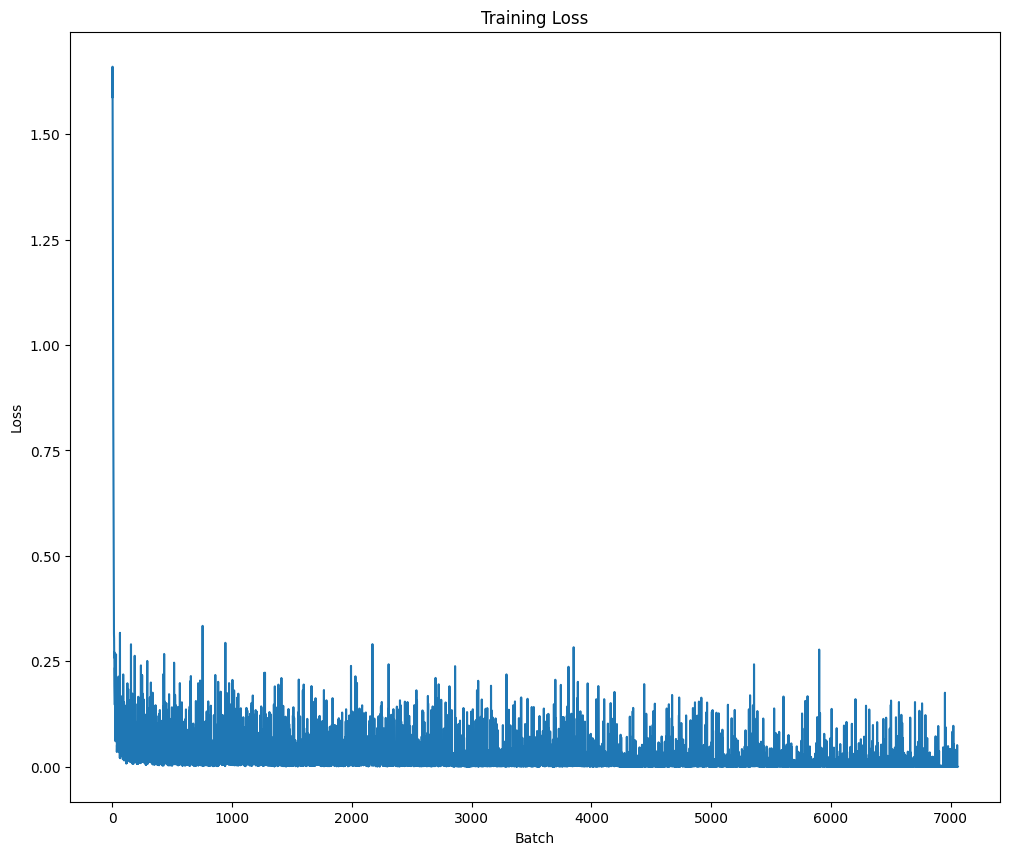

In [25]:
# Picture of Train Loss
plt.figure(figsize=(12,10))
plt.title("Training Loss")
plt.xlabel("Batch")
plt.ylabel("Loss")
plt.plot(train_loss)
plt.show()

####  Model Evaluation

In [29]:
# Test Data
df = pd.read_csv("/content/drive/MyDrive/data/crime_data/text_data.txt", delimiter='\t', header=None, names=['label', 'sentence'], on_bad_lines='skip')

In [30]:
df['label'] = df['label'].map(replace_label)

string_labels = df['label'].apply(lambda x: isinstance(x, str)).sum()
if string_labels > 0:
    print(f"Warning: {string_labels} labels were not mapped to numeric values.")
    df = df[df['label'].apply(lambda x: isinstance(x, (int, float)))]
    print(f"Removed {string_labels} rows with string labels.")
else:
    print("All labels were successfully mapped to numeric values.")

Removed 2 rows with string labels.


In [31]:
sentences = df.sentence.values
sentences = add_sepreate(sentences)

labels = df.label.values

In [32]:
tokenizer = BertTokenizer.from_pretrained("bert-base-chinese")
max_len = 256
test_ids = tokenizer(sentences, padding=True, truncation=True, max_length=max_len, return_tensors='pt')

In [33]:
labels[:5]

array([0, 0, 0, 0, 0], dtype=object)

In [34]:
# to tensor
sentence_ids = torch.tensor(test_ids['input_ids'])
attention_mask = torch.tensor(test_ids['attention_mask'])

labels = torch.tensor(labels.astype(int))

In [35]:
# Package
test_dataset = TensorDataset(test_ids['input_ids'], test_ids['attention_mask'], labels)
test_dataloader = DataLoader(test_dataset, batch_size, shuffle=True)

In [36]:
# Test

# eval
model.eval()

test_loss, test_acc = 0.0, 0.0
steps = 0
num = 0

for batch in test_dataloader:
    # To GPU
    batch = tuple(data.to(device) for data in batch)
    # Resolve
    inputs_ids, inputs_masks, inputs_labels = batch
    # no need to calculate gradients during verification
    with torch.no_grad():
        preds = model(inputs_ids, token_type_ids=None, attention_mask=inputs_masks) # 模型预测
    # Strip from calculation graph & do not calculate gradients
    preds = preds['logits'].detach().to('cpu').numpy()
    inputs_labels = inputs_labels.to('cpu').numpy()
    # step acc
    batch_acc = np.mean(np.argmax(preds, axis=1) == inputs_labels)
    # total acc
    test_acc += batch_acc
    # total steps
    steps += 1
    # total sample
    num += inputs_ids.size(0)

print("steps = ", steps)
print("test number = ", num)
print("test acc : {:.4f}".format(test_acc / steps))

steps =  157
test number =  9991
test acc : 0.9831


In [37]:
# save model
torch.save(model, '/content/drive/MyDrive/data/crime_data/crime_model.pt')

# load model
#loaded_model = torch.load('model.pt')
#loaded_model.eval()

In [38]:
# Create a dictionary of inverse mappings from values to labels
reverse_label_map = {value: key for key, value in label_map.items()}

def get_label_name(label_value):
    if label_value in reverse_label_map:
        return reverse_label_map[label_value]
    else:
        return "Unknown Label"

In [42]:
test_input = input("Please input details of the news: ")
test_ids = tokenizer(test_input, padding=True, truncation=True, max_length=max_len, return_tensors='pt')
input_ids = test_ids['input_ids'].to(device)
attention_mask = test_ids['attention_mask'].to(device)
# eval
model.eval()

# Predict
with torch.no_grad():
    outputs = model(input_ids, attention_mask=attention_mask)
    logits = outputs['logits']

# result
predicted_label = torch.argmax(logits, dim=1).item()
label_name = get_label_name(predicted_label)

print("Predicted label:", predicted_label)
print("Crime:", label_name)


Please input details of the news: 经审理查明：2014年6月19日，被告人叶某驾驶浙g×××××号小型轿车，沿孝孔线由西向东行驶，19时15分许，行驶至金华市金某区孝顺镇严店村路段时，与对向被害人严某乙驾驶的无号牌人力三轮车发生碰撞，造成严某乙受伤及两车损坏的交通事故。被害人严某乙经医院抢救无效于次日死亡。案发后，被告人叶某主动报警并在现场等候交警前来处理。金华市公安司法鉴定中心法医学尸表检验意见书认定：被害人严某乙系因交通事故致颅脑损伤合并失血性休克而死亡。华市公安局交警支队直属二大队道路交通事故认定书认定，被告人叶某承担本次事故的全部责任。案的民事赔偿问题，双方当事人达成和解协议，赔偿款已实际履行，被害人亲属对被告人叶某表示谅解。述事实，被告人叶某在开庭审理过程中亦无异议，并有被告人叶某的身份证明；接警记录单；破案经过；和解协议；情况说明；谅解书；证人严某甲的证言；被害人的死亡医学证明书；被告人叶某的供述和辩解；道路交通事故现场勘查笔录；道路交通事故现场图；道路交通事故认定书；法医学尸表检验意见书；交通事故车辆技术检验报告等证据证实，足以认定。
Predicted label: 4
Crime: 交通肇事罪
